In [200]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import main_module as mm
from pypoman import compute_polytope_vertices
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon
import os
import importlib

### Test Code. Compute the Stoichiometric Ray of the reversible Brusselator

In [201]:
importlib.reload(mm)
os.makedirs('Brusselator/',exist_ok=True)
target = 'B'
target_states = {'A':np.array([[0.6,0.6],[0.6,0.59]]),'B':np.array([[1.5,1.5],[1.51,1.51]])}

In [202]:
def compute_polytope(start_polytope_vetices, sigma, k, S, subs, prod):
    N = np.shape(S)[0]
    A, b = mm.ConstructMatrix(start_polytope_vetices, sigma, k, S, subs, prod, model='Brusselator')
    vertices = compute_polytope_vertices(A, b)
    
    vertices = mm.reduce_vertices(vertices, S, start_polytope_vetices)
    if len(vertices) > 2:
        hull = ConvexHull(vertices)
        vertices = vertices[hull.vertices]

    return vertices


In [203]:
MAX_PATH_LENGTH = 5
k = [1.0/0.75,2.,2.]
S = np.array([[1,-1,1],[0,1,-1]])
N, R = np.shape(S)
subs, prod = [[], [0], [1]], [[0],[1],[0]] 
paths = list(itertools.product([i for i in range(R)], repeat=MAX_PATH_LENGTH))

In [204]:
#paths = [(1,0)]
polytopes_all = []
extreme_points_all = []
start_points_all = []
for single_path in paths:
    start_polytope_vetices = target_states[target].copy()
    #start_polytope_vetices = np.array([[1.5,1.5],[1.51,1.51]])
    sigma = mm.compute_flux_sign(start_polytope_vetices[0],k)

    extreme_points = []
    start_points = []
    vertices = compute_polytope(start_polytope_vetices, sigma, k, S, subs, prod)
    start_points.append(start_polytope_vetices)
    extreme_points.append(vertices)

    for i, p in enumerate(single_path):
        
        vertices_on_manifolds = mm.vertices_on_manifolds_Brusselator(vertices,k)
        if vertices_on_manifolds[p].size < 2*N:
            #print('no more vertices on manifold')
            break
        #print(vertices_on_manifolds[p])
        sigma[p] = - sigma[p]
        #print(f'sigma={sigma}')
        vertices = compute_polytope(vertices_on_manifolds[p], sigma, k, S, subs, prod)
        start_points.append(vertices_on_manifolds[p])
        extreme_points.append(vertices)
        
    if len(extreme_points) > 1:
        polytopes_all.append(extreme_points)
        start_points_all.append(start_points)
        extreme_points_all.append(extreme_points)


making polytope union is quite tricky and can lead to weird result. 

I decided to polytope union manually

### Visualization of ray extension for two specific paths. 

This is a code for the start point as $(0.6,0.6)$



In [205]:
if target == 'A':
    fig, ax = mm.plot_initialize(k)
    path_index = 60
    for i in range(len(extreme_points_all[path_index])):
        hatch = 'ox'
        start_points = start_points_all[path_index][i][0,:].reshape(-1,1).T
        if i > 0:
            hatch = 'o'
            start_points = []
        mm.plot_polytope(fig,ax,start_points,extreme_points_all[path_index][i],i%5,hatch=hatch)
    path_index = 100
    for i in range(1,len(extreme_points_all[path_index])):
        mm.plot_polytope(fig,ax,[],extreme_points_all[path_index][i],i%5,hatch='x')

    fig.savefig(f'Brusselator/Brusselator_{target}_tworays.svg', format='svg')  # Saves as an SVG file
    fig.savefig(f'Brusselator/Brusselator_{target}_tworays.png',dpi=512)  # Saves as an PNG file



### Manualy picked-up union polygons

Polygon union using shapely failed by some reason (too many polytopes?)

In [206]:
if target == 'A':
    union_polytope = {0:[[[0,0],[0.4,0.8],[0.75,0.45],[0.75,0.375]]],
                      1:[[[0.75 , 1.5], [0.75 , 0.375],[2,1],[2,4]], [[0,0],[0.75,0.375],[0.75,0]],[[0,0],[0.4,0.8],[0,1.2]]],
                      2:[[[0,0],[0.75,0.375],[0.75,1.5]],[[0.75,0],[2,0],[2,1],[0.75,0.375]],[[0.75, 1.5], [2.0, 4.0], [0.75, 4.0]]],
                      3:[[[2.0, 4.0], [0.75, 1.5],[0.75, 0.375],[2.0, 1.0]],[[0.0, 0.0], [0.75, 0], [0.75, 0.375]],[[0.0, 4.0], [0, 0], [0.75, 1.5], [0.75, 4.0]]]}
if target == 'B':
    union_polytope = {0:[[[2.0, 4.0], [1.0, 2.0], [2.0, 1.0]]],
                      1:[[[2.0, 4.0],[0.75, 4.0],[0.75, 2.25],[1.0, 2.0]]],
                      2:[[[0, 4.0],[0, 2.25],[0.75, 2.25],[0.75, 4.0]]]}

### Visualization of the union polygon with different color for different generation

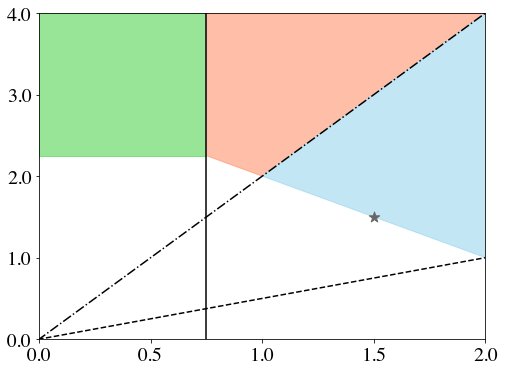

In [207]:
importlib.reload(mm)
fig, ax = mm.plot_initialize(k)
for i in reversed(range(len(union_polytope))):
    for p in union_polytope[i]:
        if i == 0:
            start_points = target_states[target][0,:].reshape(-1,1).T
        else:
            start_points = []
        mm.plot_polytope(fig,ax,[],np.array(p),-1,alpha=1.0)
        mm.plot_polytope(fig,ax,start_points,np.array(p),i%4)
plt.show()
fig.savefig(f'Brusselator/Brusselator_{target}.svg', format='svg')  # Saves as an SVG file
fig.savefig(f'Brusselator/Brusselator_{target}.png',dpi=512)  # Saves as an PNG file


## Total Volume of polytope at given generation

Union computation worked for this size of the polygons with shapely

In [208]:
vol = []
polytope = Polygon(union_polytope[0][0])
vol.append(polytope.area)
for i in range(1,len(union_polytope)):
    for p in union_polytope[i]:
        vertices = mm.sort_points(np.array(p))
        new_polytope = Polygon(vertices)
        polytope = polytope.union(new_polytope)
    vol.append(polytope.area)
vol.append(vol[-1])
vol.append(vol[-1])
with open(f'Brusselator/volume_tgt{target}.txt','w') as f:
    for i,v in enumerate(vol):
        f.write(f'{i} {v}\n')


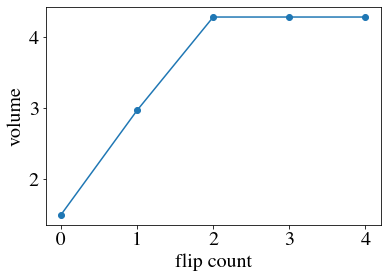

In [209]:
# plot volume change
fig, ax = plt.subplots()
ax.plot(vol, 'o-')
ax.set_xlabel('flip count')
ax.set_ylabel('volume')
plt.show()